In [1]:
!pip install tensorflow_addons

import tensorflow_addons as tfa

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50, VGG16, VGG19, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import time

from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 2.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Importing the data

In [2]:
!gdown 1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc

Downloading...
From (original): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc
From (redirected): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc&confirm=t&uuid=b01a93ba-e3e8-4be4-8a71-9fa17bb31de2
To: /content/Images for project.zip
100% 1.42G/1.42G [00:35<00:00, 40.2MB/s]


In [3]:
!unzip -q "/content/Images for project.zip" -d /content/

In [4]:
!rm '/content/Images for project.zip'

#### Sorting the images into separate train-val-test folders

In [5]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

In [6]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [7]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [8]:
proportion = {
    'train': 0.70,
    'val': 0.10,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

split
train    0.687712
test     0.188800
val      0.123488
Name: count, dtype: float64

In [9]:
df[['label', 'fitzpatrick_scale', 'split']].value_counts().reset_index().sort_values(by = ['label','fitzpatrick_scale']).head(50)

,label,fitzpatrick_scale,split,count
1853,acanthosis nigricans,-1,val,1
2056,acanthosis nigricans,-1,train,1
750,acanthosis nigricans,1,train,6
1614,acanthosis nigricans,1,test,2
1633,acanthosis nigricans,1,val,1
653,acanthosis nigricans,2,train,7
1590,acanthosis nigricans,2,test,2
1594,acanthosis nigricans,2,val,2
287,acanthosis nigricans,3,train,16
907,acanthosis nigricans,3,test,4


In [10]:
shutil.rmtree('/content/dataset', ignore_errors=True)

source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

/content/Images for project/img?imageId=4030  doesn't exist
/content/Images for project/img?imageId=8364  doesn't exist
/content/Images for project/img?imageId=2767  doesn't exist
/content/Images for project/img?imageId=4031  doesn't exist
/content/Images for project/img?imageId=5399  doesn't exist
/content/Images for project/img?imageId=2766  doesn't exist
/content/Images for project/img?imageId=6724  doesn't exist
/content/Images for project/img?imageId=4505  doesn't exist
/content/Images for project/img?imageId=8362  doesn't exist
/content/Images for project/img?imageId=8363  doesn't exist


#### Defining data generators

In [33]:
class CustomDirectoryIterator(DirectoryIterator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        class_counts = Counter(self.classes)
        total_samples = sum(class_counts.values())
        self.class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        self.sampled_classes = []

    def __next__(self):
        batch_x, batch_y = super().__next__()
        sampled_indices = np.random.choice(len(batch_x),
                                           size=len(batch_x),
                                           p=[self.class_weights[np.where(cls == 1)[0][0]] for cls in batch_y] /
                                             np.sum([self.class_weights[np.where(cls == 1)[0][0]] for cls in batch_y]))
        self.sampled_classes = np.where(batch_y[sampled_indices] == 1)[1]
        return batch_x[sampled_indices], batch_y[sampled_indices]

    def __getitem__(self, idx):
        batch_x, batch_y = super().__getitem__(idx)

        sampled_indices = np.random.choice(len(batch_x),
                                           size=len(batch_x),
                                           p=[self.class_weights[np.where(cls == 1)[0][0]] for cls in batch_y] /
                                             np.sum([self.class_weights[np.where(cls == 1)[0][0]] for cls in batch_y]))
        self.sampled_classes = np.where(batch_y[sampled_indices] == 1)[1]
        return batch_x[sampled_indices], batch_y[sampled_indices]

class OversamplingImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        return CustomDirectoryIterator(*args, image_data_generator = self, **kwargs)



In [48]:
# train_datagen = OversamplingImageDataGenerator(rescale=1./255,
#                                     rotation_range=30,
#                                     # width_shift_range=0.2,
#                                     # height_shift_range=0.2,
#                                     # shear_range=0.2,
#                                     zoom_range=0.3,
#                                     brightness_range = (0.8, 1.2),
#                                    horizontal_flip=True)
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=30,
                                    # width_shift_range=0.2,
                                    # height_shift_range=0.2,
                                    # shear_range=0.2,
                                    zoom_range=0.3,
                                    brightness_range = (0.8, 1.2),
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
input_size = (224,224)

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical',
        target_size = input_size)

val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = input_size)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = input_size)

Found 11366 images belonging to 114 classes.
Found 2042 images belonging to 114 classes.
Found 3118 images belonging to 114 classes.


#### Creating Callbacks

In [52]:
def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(np.argsort(y_val, axis = 1)[:,-n:] - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)


class TopNAccuracyCallback(Callback):
  def __init__(self, val_generator):
      super().__init__()
      self.val_generator = val_generator

  def on_epoch_end(self, epoch, logs=None):
      start_time = time.time()
      top_1_acc = []
      top_3_acc = []
      top_5_acc = []
      for x_val_batch, y_val_batch in self.val_generator:
        val_predictions = self.model.predict(x_val_batch, verbose = 0)
        top_1_acc.append(top_n_accuracy(y_val_batch, val_predictions, 1))
        top_3_acc.append(top_n_accuracy(y_val_batch, val_predictions, 3))
        top_5_acc.append(top_n_accuracy(y_val_batch, val_predictions, 5))
        if len(top_1_acc) >= len(self.val_generator):
          break
      end_time = time.time()
      duration = end_time - start_time
      print(f'Top-1 accuracy: {np.mean(top_1_acc):.3f}, Top-3 accuracy: {np.mean(top_3_acc):.3f}, Top-5 accuracy: {np.mean(top_5_acc):.3f}, \nTime to calculate: {duration:.2f} seconds')
top_n_accuracy_callback = TopNAccuracyCallback(val_generator)

In [53]:
class PlotMetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), self.losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()


        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), self.accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_metrics_callback = PlotMetricsCallback()

In [54]:
clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)

In [55]:
weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1')
macro_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'macro', name = 'macro_f1')

In [56]:
def scheduler(epoch, lr):
  if epoch > 15:
    return 0.000001
  if epoch > 10:
    return 0.00001
  if epoch > 5:
    return 0.0001
  else:
    return lr


scheduler_callback = LearningRateScheduler(scheduler)

#### EfficientNet


In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape = input_size + (3,) )


x = GlobalAveragePooling2D()(model.output) # instead of flatten to reduce number of parameters

dense = layers.Dense(1024, activation='relu')(x)
dropout = Dropout(0.5)(dense)

dense = layers.Dense(512, activation='relu')(dropout)
dropout = Dropout(0.5)(dense)

output = layers.Dense(114, activation='softmax')(dropout)

model = Model(inputs=model.input, outputs=output)

for layer in model.layers[:-6]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score, macro_f1_score])

In [ ]:
history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=20,
          steps_per_epoch=len(train_generator),
          validation_steps = len(val_generator),
          callbacks=[scheduler_callback, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
          verbose = 'auto')

In [ ]:
model.save_weights('/content/drive/MyDrive/eff_25_04_adam.h5')

### Handmade model

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),

    MaxPooling2D((4, 4)),
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),

    MaxPooling2D((4, 4)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),

    # MaxPooling2D((2, 2)),
    # Conv2D(128, (3, 3), activation='relu'),
    # BatchNormalization(),

    # MaxPooling2D((2, 2)),
    # Conv2D(128, (3, 3), activation='relu'),
    # BatchNormalization(),

    Flatten(),

    # Dense(512, activation='relu'),
    # Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(114, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 batch_normalization_43 (Ba  (None, 220, 220, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 55, 55, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 51, 51, 64)        51264     
                                                                 
 batch_normalization_44 (Ba  (None, 51, 51, 64)        256       
 tchNormalization)                                               
                                                     

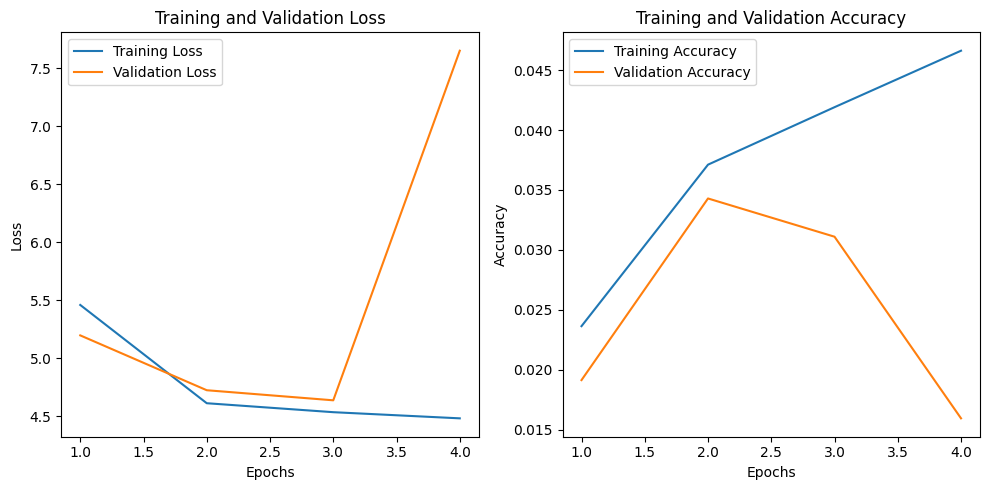

Top-1 accuracy: 0.014, Top-3 accuracy: 0.014, Top-5 accuracy: 0.017, 
Time to calculate: 9.36 seconds
379/379 [==============================] - 233s 614ms/step - loss: 4.4834 - accuracy: 0.0466 - f1_score: 0.0161 - val_loss: 7.6528 - val_accuracy: 0.0159 - val_f1_score: 0.0033
Epoch 5/10
107/379 [=======>......................] - ETA: 2:35 - loss: 4.4554 - accuracy: 0.0479 - f1_score: 0.0169

KeyboardInterrupt: 

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       weighted_f1_score
                       ])

history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          steps_per_epoch=len(train_generator),
          validation_steps = len(val_generator),
          callbacks=[clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
          verbose = 'auto')

### VGG 19

In [62]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape = input_size + (3,) )

for layer in vgg.layers[:-2]:
    layer.trainable = False

In [63]:
flatten = layers.Flatten()(vgg.output)

dense = layers.Dense(1024, activation='relu')(flatten)
dropout = Dropout(0.5)(dense)

dense = layers.Dense(512, activation='relu')(dropout)
dropout = Dropout(0.5)(dense)

output = layers.Dense(114, activation='softmax')(dropout)

model = models.Model(vgg.input, output)




In [64]:
model.compile(optimizer=Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score, macro_f1_score])

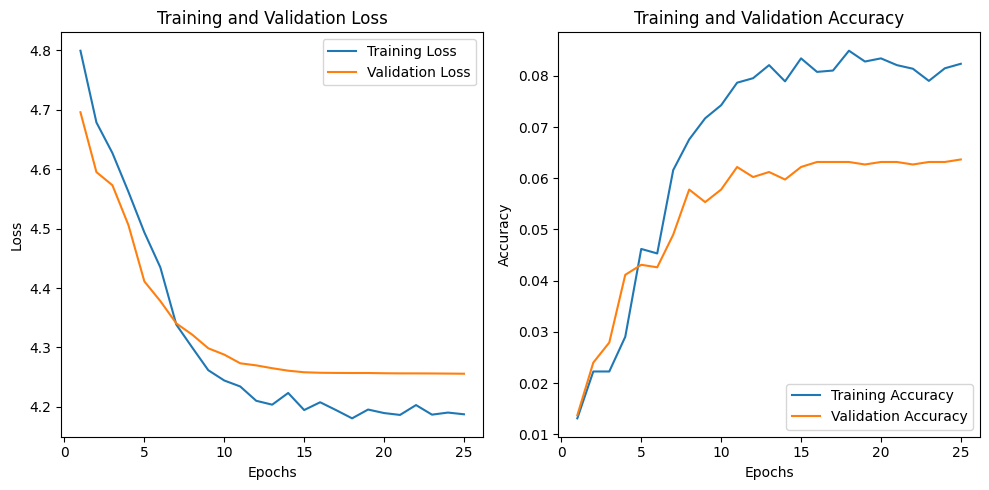

Top-1 accuracy: 0.064, Top-3 accuracy: 0.078, Top-5 accuracy: 0.083, 
Time to calculate: 25.58 seconds
178/178 [==============================] - 251s 1s/step - loss: 4.1877 - accuracy: 0.0824 - weighted_f1: 0.0643 - macro_f1: 0.0632 - val_loss: 4.2559 - val_accuracy: 0.0637 - val_weighted_f1: 0.0420 - val_macro_f1: 0.0459 - lr: 1.0000e-06
Epoch 26/30
 67/178 [==========>...................] - ETA: 2:11 - loss: 4.1731 - accuracy: 0.0826 - weighted_f1: 0.0646 - macro_f1: 0.0644

KeyboardInterrupt: 

In [47]:
#training with oversampling data generator

history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=30,
          steps_per_epoch=len(train_generator),
          validation_steps = len(val_generator),
          callbacks=[scheduler_callback, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
          verbose = 'auto')


In [ ]:
model.save_weights('/content/drive/MyDrive/vgg19_25_04_adam.h5')

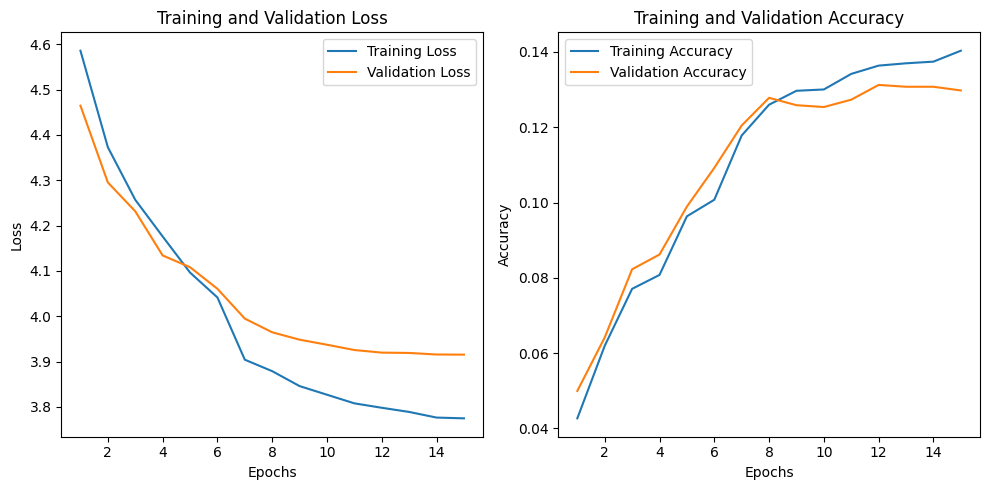

Top-1 accuracy: 0.130, Top-3 accuracy: 0.142, Top-5 accuracy: 0.146, 
Time to calculate: 26.96 seconds
178/178 [==============================] - 245s 1s/step - loss: 3.7748 - accuracy: 0.1403 - weighted_f1: 0.1070 - macro_f1: 0.0758 - val_loss: 3.9153 - val_accuracy: 0.1298 - val_weighted_f1: 0.0946 - val_macro_f1: 0.0739 - lr: 1.0000e-05


In [65]:
#training without oversampling data generator

history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=15,
          steps_per_epoch=len(train_generator),
          validation_steps = len(val_generator),
          callbacks=[scheduler_callback, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
          verbose = 'auto')

In [ ]:
model.save_weights('/content/drive/MyDrive/vgg19_25_04_adam.h5')

In [73]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape = input_size + (3,) )

for layer in vgg.layers[:-4]:
    layer.trainable = False

flatten = layers.Flatten()(vgg.output)

dense = layers.Dense(1024, activation='relu')(flatten)
dropout = Dropout(0.5)(dense)

dense = layers.Dense(512, activation='relu')(dropout)
dropout = Dropout(0.5)(dense)

output = layers.Dense(114, activation='softmax')(dropout)

model = models.Model(vgg.input, output)

model.compile(optimizer=SGD(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score, macro_f1_score])

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


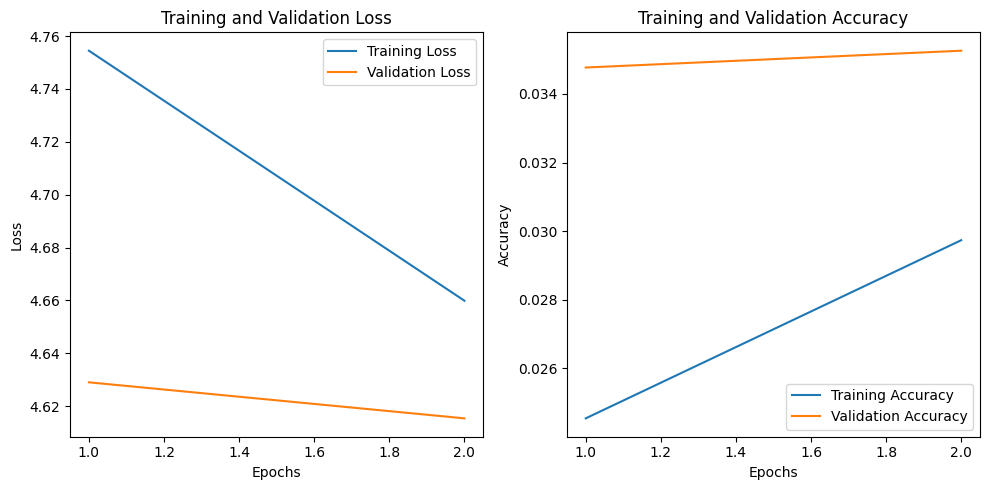

In [ ]:
history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=5,
          steps_per_epoch=len(train_generator),
          validation_steps = len(val_generator),
          callbacks=[scheduler_callback, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
          verbose = 'auto')

In [71]:
model.save_weights('/content/drive/MyDrive/vgg19_25_04_sgd.h5')

#### VGG 16

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape = input_size + (3,) )

for layer in vgg.layers:
    layer.trainable = False

flatten = layers.Flatten()(vgg.output)

dense = layers.Dense(1024, activation='relu')(flatten)
dropout = Dropout(0.5)(dense)

dense = layers.Dense(256, activation='relu')(dropout)
dropout = Dropout(0.5)(dense)

output = layers.Dense(114, activation='softmax')(dropout)

model = models.Model(vgg.input, output)

model.compile(optimizer=Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score, macro_f1_score])

In [ ]:
history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=30,
          steps_per_epoch=len(train_generator),
          validation_steps = len(val_generator),
          callbacks=[scheduler_callback, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
          verbose = 'auto')

In [ ]:
# Train the model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

Epoch 1/10
379/379 [==============================] - 214s 565ms/step - loss: 4.5626 - accuracy: 0.0496 - val_loss: 4.6065 - val_accuracy: 0.0439
Epoch 2/10
379/379 [==============================] - 209s 550ms/step - loss: 4.2871 - accuracy: 0.0688 - val_loss: 4.4079 - val_accuracy: 0.0566
Epoch 3/10
379/379 [==============================] - 208s 548ms/step - loss: 4.1713 - accuracy: 0.0774 - val_loss: 4.2941 - val_accuracy: 0.0797
Epoch 4/10
379/379 [==============================] - 212s 560ms/step - loss: 4.0789 - accuracy: 0.0922 - val_loss: 4.2698 - val_accuracy: 0.0813
Epoch 5/10
379/379 [==============================] - 212s 558ms/step - loss: 4.0069 - accuracy: 0.0995 - val_loss: 4.1700 - val_accuracy: 0.0949
Epoch 6/10
379/379 [==============================] - 203s 535ms/step - loss: 3.9411 - accuracy: 0.1079 - val_loss: 4.1259 - val_accuracy: 0.0973
Epoch 7/10
379/379 [==============================] - 205s 541ms/step - loss: 3.8945 - accuracy: 0.1151 - val_loss: 4.0923 -

In [ ]:
model.save_weights('/content/vgg16_adam.h5')